In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

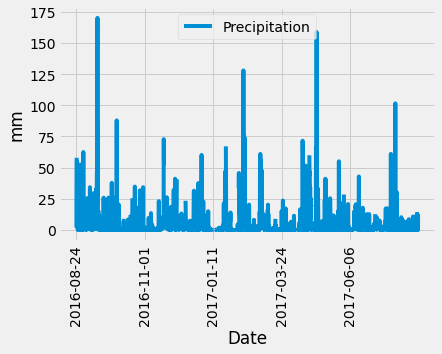

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_query, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.reset_index(inplace = True)
precipitation_df.plot(x='Date', y='Precipitation', 
                      kind='line', rot=90, xticks=precipitation_df.index[::len(precipitation_df.index) // 5 + 1])
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = (session.query(Measurement.station, func.count(Measurement.station))
                    .group_by(Measurement.station)
                    .order_by(func.count(Measurement.station).desc()).all())

most_active_station_id = station_activity[0][0]

print("Stations with their activity count in descending order:")
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Stations with their activity count in descending order:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temps = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                            func.avg(Measurement.tobs))
                              .filter(Measurement.station == most_active_station_id).all())
low_temp, high_temp, avg_temp = most_active_station_temps[0]
print(f"For Station {most_active_station_id} the lowest temperature was: {round(low_temp,2)}\u00b0, while the highiest temperature was: {round(high_temp,2)}\u00b0 and the average temperature was: {round(avg_temp,2)}\u00b0")

For Station USC00519281 the lowest temperature was: 12.2°, while the highiest temperature was: 29.4° and the average temperature was: 22.04°


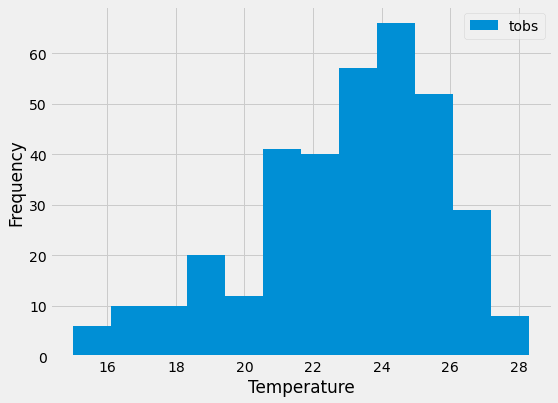

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temps_12mo = (session.query(Measurement.tobs)
                                   .filter(Measurement.station == most_active_station_id)
                                   .filter(Measurement.date >= one_year_ago).all())
most_active_station_temps_12mo = [temp[0] for temp in most_active_station_temps_12mo]
plt.figure(figsize=(8,6))
plt.hist(most_active_station_temps_12mo, bins=12, label = "tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [16]:
# Close Session
session.close()